# Fairness and Explainability with SageMaker Clarify - Bias Detection With Predicted Label and Facet Datasets

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

---

## Runtime

This notebook takes approximately 15 minutes to run.

## Contents

1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Initialize SageMaker](#Initialize-SageMaker)
    1. [Download data](#Download-Data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Data encoding and upload to S3](#Encode-and-Upload-the-Dataset) 
1. [Train and Deploy XGBoost Model](#Train-and-Deploy-XGBoost-Model)
    1. [Train Model](#Train-Model)
    1. [Deploy Endpoint](#Deploy-Endpoint)
    1. [Predicted Labels](#Predicted-Labels)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Detecting Bias](#Detecting-Bias-with-Predicted-Labels)
        1. [Writing BiasConfig](#Writing-BiasConfig)
        1. [Pre-training Bias](#Pre-training-Bias)
        1. [Post-training Bias with Predicted Labels](#Post-training-Bias)
        1. [Viewing the Bias Report](#Viewing-the-Bias-Report)
1. [Clean Up](#Clean-Up)

## Overview

Amazon SageMaker Clarify provides you the ability to improve your machine learning models by detecting potential biases in your model and data. Specifically, Clarify can help you measure biases that can occur during each stage of the ML lifecycle (data collection, model training and tuning, and monitoring of ML models deployed for inference). 

In some cases, you may already have model predictions that you would like to use for bias detection instead of having Clarify make model inference calls. Additionally, there are cases where models are trained without sensitive attributes, but you would still like to evaluate the dataset and model with respect to the sensitive attributes to understand and mitigate bias. This sample notebook demonstrates both of these cases and will walk you through:

1. Key terms and concepts needed to understand SageMaker Clarify
1. Measuring the pre-training bias of a dataset and post-training bias of a model
1. Accessing the bias report

We will first train a [SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) model, use it to get model predictions, then use SageMaker Clarify to analyze the pre- and post-training bias on the dataset and predicted labels dataset and demonstrate how to provide a separate facet dataset that is not used during model training. If you would like to use a deployed model or endpoint to analyze your dataset or explain model predictions, please visit [this notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-clarify/fairness_and_explainability/fairness_and_explainability.ipynb). You can find the detailed documentation of SageMaker Clarify at [What Is Fairness and Model Explainability for Machine Learning Predictions](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-fairness-and-explainability.html) and more demo notebooks at [aws-sagemaker-examples GitHub repository](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-clarify).

## Prerequisites and Data

Let's start by installing the required packages.

### Initialize SageMaker

In [2]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify-bias-with-predicted-labels"
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer
import pandas as pd
import numpy as np
import os
import boto3
from datetime import datetime

role = get_execution_role()
s3_client = boto3.client("s3")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/17/25 15:12:34] INFO     Found credentials from IAM Role:                                   ]8;id=405545;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=331421;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[03/17/25 15:12:35] INFO     Found credentials from IAM Role:                                   ]8;id=907505;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=607337;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/17/25 15:12:36] INFO     Found credentials from IAM Role:                                   ]8;id=205288;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=844306;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=684482;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=467187;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

### Download Data

Data Source: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

Let's __download__ the data and save it in the local folder with the name adult.data and adult.test from UCI repository$^{[1]}$.

$^{[1]}$Dua Dheeru, and Efi Karra Taniskidou. "UCI Machine Learning Repository". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [3]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}",
        "datasets/tabular/uci_adult/adult.data",
        "adult.data",
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}",
        "datasets/tabular/uci_adult/adult.test",
        "adult.test",
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data saved!
adult.test saved!


### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:

1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next, we specify our binary prediction task:  
15. **Target**: <=50,000, >\\$50,000.

In [4]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data inspection

Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered sensitive.
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

<Axes: title={'center': 'Counts of Sex'}>

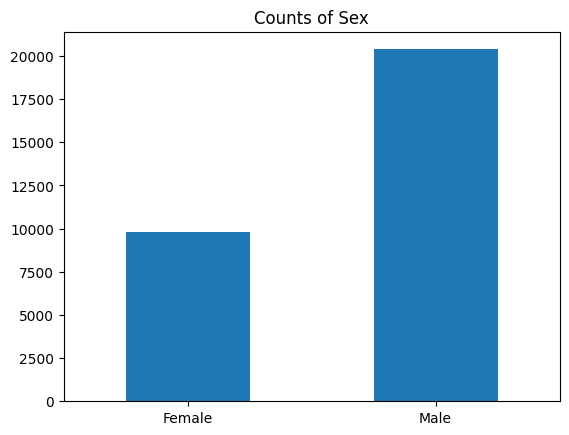

In [5]:
%matplotlib inline
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

<Axes: title={'center': 'Counts of Sex earning >$50K'}>

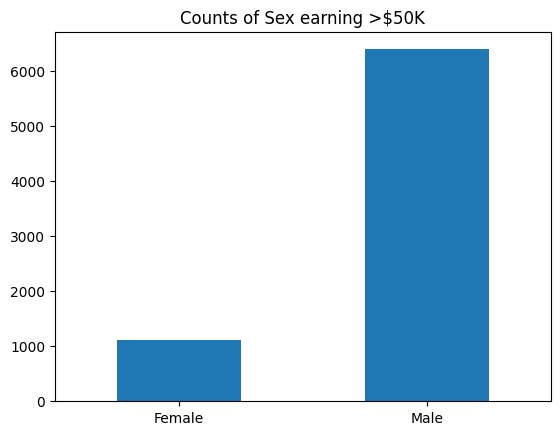

In [6]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

### Encode and Upload the Dataset

Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for the model.

In [7]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders

In some cases, you may want to exclude certain sensitive features from being used to train the model but still want to analyze the pre- and post-training bias on the entire dataset including the sensitive facet columns. Here we will take the features `Ethnic Group` and `Sex` as the sensitive facet columns and exclude them from the training data and testing data, storing them in a separate facet dataset to be used in bias detection.

In [8]:
facet_data = training_data[["Ethnic group", "Sex"]].copy()
training_data = training_data.drop(["Ethnic group", "Sex"], axis=1)
testing_data = testing_data.drop(["Ethnic group", "Sex"], axis=1)

training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
testing_data.to_csv("test_data.csv", index=False, header=False)

facet_data, _ = number_encode_features(facet_data)
facet_data.to_csv("facet_data.csv", index=False, header=False)

A quick note about our encoding: the "Female" Sex value has been encoded as 0 and "Male" as 1.

In [9]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,0,0,40,4


Lastly, let's upload the data to S3.

In [10]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_data.csv", "s3://{}/{}".format(bucket, prefix))
facet_uri = S3Uploader.upload("facet_data.csv", "s3://{}/{}".format(bucket, prefix))

### Train and Deploy XGBoost Model
#### Train Model

Since our focus is on understanding how to use SageMaker Clarify, we keep it simple by using a standard XGBoost model.

In [11]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)

[03/17/25 15:13:08] INFO     Ignoring unnecessary instance type: None.                            ]8;id=755621;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=180877;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=657325;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=715885;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=20902;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=270947;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-03-17-15-13-08-117                                             


..25-03-17 15:13:09 Starting - Starting the training job
..25-03-17 15:13:24 Starting - Preparing the instances for training
....-03-17 15:13:42 Downloading - Downloading input data
........17 15:14:07 Downloading - Downloading the training image
...5-03-17 15:14:53 Training - Training image download completed. Training in progress.
..25-03-17 15:15:14 Uploading - Uploading generated training model
2025-03-17 15:15:27 Completed - Training job completed


In [12]:
model_name = "DEMO-clarify-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

[03/17/25 15:18:17] INFO     Creating model with name: DEMO-clarify-model-17-03-2025-15-18-17       ]8;id=913005;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=445018;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

'DEMO-clarify-model-17-03-2025-15-18-17'

#### Deploy Endpoint

Now we can deploy the model to an endpoint and use the endpoint to make predictions on the test dataset.

In [13]:
xgb_endpoint_name = "DEMO-clarify-endpoint-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

xgb_predictor = xgb.deploy(
    endpoint_name=xgb_endpoint_name,
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=CSVSerializer(),
)

[03/17/25 15:18:21] INFO     Creating model with name: sagemaker-xgboost-2025-03-17-15-18-21-027    ]8;id=963182;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=4698;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=752689;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=755374;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\
                             DEMO-clarify-endpoint-17-03-2025-15-18-21                                             

                    INFO     Creating endpoint with name DEMO-clarify-endpoint-17-03-2025-15-18-21  ]8;id=167969;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=268177;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

--------!

#### Predicted Labels

Now we can make predictions with the predictor on the dataset.

In [14]:
import numpy as np


def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, xgb_predictor.predict(array).decode("utf-8")])
    return np.fromstring(predictions[1:], sep=",")


predicted_labels = predict(training_data.to_numpy()[:, 1:])

Let's save the predicted labels as a DataFrame and upload it to S3.

In [15]:
predicted_labels_df = pd.DataFrame(predicted_labels, columns=["Target"])
predicted_labels_df.to_csv("predicted_labels.csv", index=False, header=False)
predicted_labels_uri = S3Uploader.upload(
    "predicted_labels.csv", "s3://{}/{}".format(bucket, prefix)
)

## Amazon SageMaker Clarify

Now that you have your model predictions, let's say hello to SageMaker Clarify!

In [16]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

[03/17/25 15:23:40] INFO     Ignoring unnecessary instance type: None.                            ]8;id=502257;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=581268;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

### Detecting Bias with Predicted Labels

SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics. In order to compute post-training bias metrics, SageMaker Clarify needs either a SageMaker model or endpoint provided through the `ModelConfig`, which communicates information about your trained model, or a predicted label dataset in the `DataConfig`. In this notebook, we use a predicted label dataset provided in the `DataConfig` and omit the `ModelConfig`.

#### Writing DataConfig

A `DataConfig` object communicates some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (label), the header names, and the dataset type. 

Note that the `joinsource` field, which is the name or index of the column in the dataset that acts as an identifier column, is required if either the main dataset, predicted label dataset, or facet dataset are provided in multiple files (more than one file each). If model inference is required, i.e. a predicted label dataset is not provided, Clarify will not use the joinsource column and columns present in the facet dataset when calling model inference APIs. Here we do not specify the `joinsource` field as the main dataset, predicted label dataset and facet dataset are in one file each.

Predicted labels can be provided as part of the main dataset or as a separate dataset. Here we provide it as a separate dataset. To use model predictions to compute bias metrics, we can specify:

* `predicted_label_dataset_uri`: dataset S3 prefix/object URI to the predicted label dataset if the predicted label column is not part of the main dataset. 
* `predicted_label_headers`: A list of headers in the predicted label dataset. This must contain the `joinsource` column header if the predicted label dataset is provided in multiple files.
* `predicted_label`: the header corresponding to the predicted label. Only this field needs to be provided if the predicted label column is part of the main dataset. 

To do bias analysis when the facet dataset is provided separately, we specify:

* `facet_dataset_uri`: dataset S3 prefix/object URI that contains facet attribute(s). If the facet dataset is in multiple files, the `joinsource` field is required to join the datasets.
* `facet_headers`: List of column names in the facet dataset. This must contain the `joinsource` column header if the facet dataset is provided in multiple files.



In [17]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
facet_headers = ["Ethnic group", "Sex"]

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    dataset_type="text/csv",
    label="Target",
    headers=training_data.columns.to_list(),
    predicted_label_dataset_uri=predicted_labels_uri,
    predicted_label_headers=["Predicted_label"],
    predicted_label="Predicted_label",
    facet_dataset_uri=facet_uri,
    facet_headers=facet_data.columns.to_list(),
)

#### Writing ModelPredictedLabelConfig

A `ModelPredictedLabelConfig` provides information on the format of your predictions. XGBoost model outputs probabilities of samples, so SageMaker Clarify invokes the endpoint then uses `probability_threshold` to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value `1` and below or equal as label value `0`.

In [18]:
predictions_config = clarify.ModelPredictedLabelConfig(
    probability_threshold=0.8,
)

#### Writing BiasConfig

SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`). SageMaker Clarify can handle both categorical and continuous data for facet_values_or_threshold and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the `BiasConfig` API. Here that the positive outcome is earning >$50,000, Sex is a sensitive category, and Female respondents are the sensitive group. `group_name` is used to form subgroups for the measurement of Conditional Demographic Disparity in Labels (CDDL) and Conditional Demographic Disparity in Predicted Labels (CDDPL) with regards to Simpson’s paradox.

In [19]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name="Sex",
    facet_values_or_threshold=[0],
    group_name="Age",
)

Now we can run the analysis with the above inputs. There are two types of bias that can be measured with SageMaker Clarify, pre-training bias and post-training bias:

#### Pre-training Bias

Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and help you understand what societal biases the data may reflect. Computing pre-training bias metrics does not require a trained model or predicted label dataset.

#### Post-training Bias

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices. Computing post-training bias metrics requires a predicted label dataset or a trained model or endpoint. 


You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()`, or at the same time with `run_bias()` as shown below. The analysis should take around 5 minutes to complete.

In [20]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
    logs=False,
)

[03/17/25 15:31:35] INFO     Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Target',    ]8;id=725667;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=704448;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital                  
                             Status', 'Occupation', 'Relationship', 'Capital Gain', 'Capital Loss',                
                             'Hours per week', 'Country'], 'label': 'Target', 'facet_dataset_uri':                 
                             's3://sagemaker-us-east-2-160885266928/sagemaker/DEMO-sagemaker-clarif                
                             y-bias-with-predicted-labels/facet_data.csv', 'facet_headers':                        
                             ['Ethnic group', 'Sex'], 'predicted_label_dataset_uri':                               
                             's3://sagemaker-us-east-2-160885266928/sagemaker/DEMO-sagemaker-clarif                
                             y-bias-with-predicted-labels/predicted_labels.csv',                                   
                             'predicted_label_headers': ['Predicted_label'], 'predicted_label':                    
                             'Predicted_label', 'label_values_or_threshold': [1], 'facet':                         
                             [{'name_or_index': 'Sex', 'value_or_threshold': [0]}],                                
                             'group_variable': 'Age', 'methods': {'report': {'name': 'report',                     
                             'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'},                 
                             'post_training_bias': {'methods': 'all'}}, 'probability_threshold':                   
                             0.8}                                                                                  

                    INFO     Creating processing-job with name Clarify-Bias-2025-03-17-15-31-35-469 ]8;id=596361;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=700311;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1575\1575]8;;\

                    ERROR    Please check the troubleshooting guide for common errors:              ]8;id=891353;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=220612;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1584\1584]8;;\
                             https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-t                
                             roubleshooting.html#sagemaker-python-sdk-troubleshooting-create-proces                
                             sing-job                                                                              

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 clarify_processor.run_bias(                                                                  │
│   2 │   data_config=bias_data_config,                                                            │
│   3 │   bias_config=bias_config,                                                                 │
│   4 │   model_predicted_label_config=predictions_config,                                         │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/clarify.py:2275 in  │
│ run_bias                                                                                         │
│                                                                                                  │
│   2272 │   │   )                                                                                 │
│   2273 │   │   # when name is either not provided (is None) or an empty string ("")              │
│   2274 │   │   job_name = job_name or utils.name_from_base(self.job_name_prefix or "Clarify-Bia  │
│ ❱ 2275 │   │   return self._run(                                                                 │
│   2276 │   │   │   data_config,                                                                  │
│   2277 │   │   │   analysis_config,                                                              │
│   2278 │   │   │   wait,                                                                         │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/clarify.py:2025 in  │
│ _run                                                                                             │
│                                                                                                  │
│   2022 │   │   │   │   s3_upload_mode=ProcessingOutputHandler.get_s3_upload_mode(analysis_confi  │
│   2023 │   │   │   )                                                                             │
│   2024 │   │   │                                                                                 │
│ ❱ 2025 │   │   │   return super().run(                                                           │
│   2026 │   │   │   │   inputs=[data_input, config_input],                                        │
│   2027 │   │   │   │   outputs=[result_output],                                                  │
│   2028 │   │   │   │   wait=wait,                                                                │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/workflow/pipeline_c │
│ ontext.py:346 in wrapper                                                                         │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                                                         │
│   349                                                      

#### Viewing the Bias Report
In Studio, you can view the results under the experiments tab.

<img src="./recordings/bias_report.gif">

If you're not a Studio user yet, you can access the bias report in pdf, html and ipynb formats in the following S3 bucket:

In [ ]:
bias_report_output_path

### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [ ]:
session.delete_model(model_name)
session.delete_endpoint(xgb_endpoint_name)

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/sagemaker-clarify|fairness_and_explainability|bias_detection_with_predicted_label_and_facet_datasets.ipynb)
